<a href="https://colab.research.google.com/github/Akechi1412/Sentiment-Analysis/blob/main/notebooks/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis of Product Reviews**

## **Connect to Drive and Github responsitory**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github
# !git clone https://github.com/Akechi1412/Sentiment-Analysis.git
%cd Sentiment-Analysis
!git config --global user.email 'nguyenphong10042002@gmail.com'
!git config --global user.name 'Akechi1412'
!git fetch origin
!git reset --hard origin/main

/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/Sentiment-Analysis
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5 (delta 1), reused 5 (delta 1), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 1.88 KiB | 3.00 KiB/s, done.
From https://github.com/Akechi1412/Sentiment-Analysis
 + 2c622a5...dbc97a5 main       -> origin/main  (forced update)
HEAD is now at dbc97a5 Update utils functions


## **Data Collecting**

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('data/data - data.csv')
print(df.head())

comments = df['comment'].values
labels = df['label'].values

                       comment label  rate Unnamed: 3
0               Áo bao đẹp ạ!!   POS     5        NaN
1                  Tuyệt vời !   POS     5        NaN
2   2day ao khong giong trong.   NEG     1        NaN
3  Mùi thơm,bôi lên da mềm da.   POS     5        NaN
4            Vải đẹp, dày dặn.   POS     5        NaN


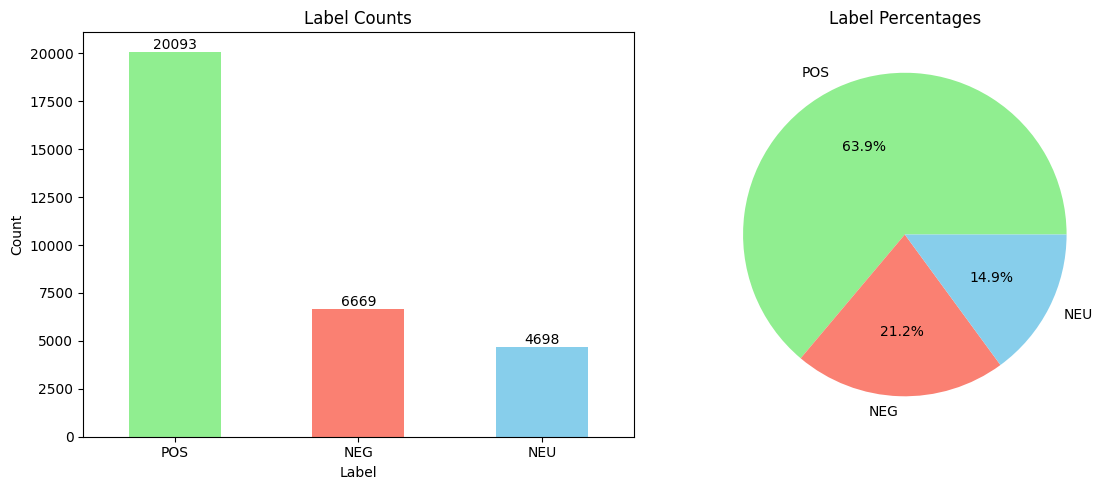

In [5]:
# Count the labels
label_counts = df['label'].value_counts()

# Calculate label percentages
label_percentages = label_counts / label_counts.sum() * 100

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Bar plot for label counts
plt.subplot(1, 2, 1)
bars = label_counts.plot(kind='bar', color=['lightgreen', 'salmon', 'skyblue'])
plt.title('Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Add the exact count on top of each bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{int(bar.get_height())}',
             ha='center', va='bottom', color='black')

# Pie chart for label percentages
plt.subplot(1, 2, 2)
label_percentages.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'salmon', 'skyblue'])
plt.title('Label Percentages')
plt.ylabel('')

plt.tight_layout()
plt.show()

In [6]:
x_train, x_temp, y_train, y_temp = train_test_split(comments, labels, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(len(x_train), len(y_train))
print(len(x_val), len(y_val))
print(len(x_test), len(y_test))

25168 25168
3146 3146
3146 3146


## **Data preprocessing**

In [7]:
!pip install underthesea emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.5 MB/s eta 0:00:00


In [8]:
from utils.data_preprocessing import clean_text, preprocess_texts
import seaborn as sns
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import pickle
from transformers import AutoTokenizer
import tensorflow as tf

In [9]:
x_train = [clean_text(comment) for comment in x_train]
x_val = [clean_text(comment) for comment in x_val]
x_test = [clean_text(comment) for comment in x_test]

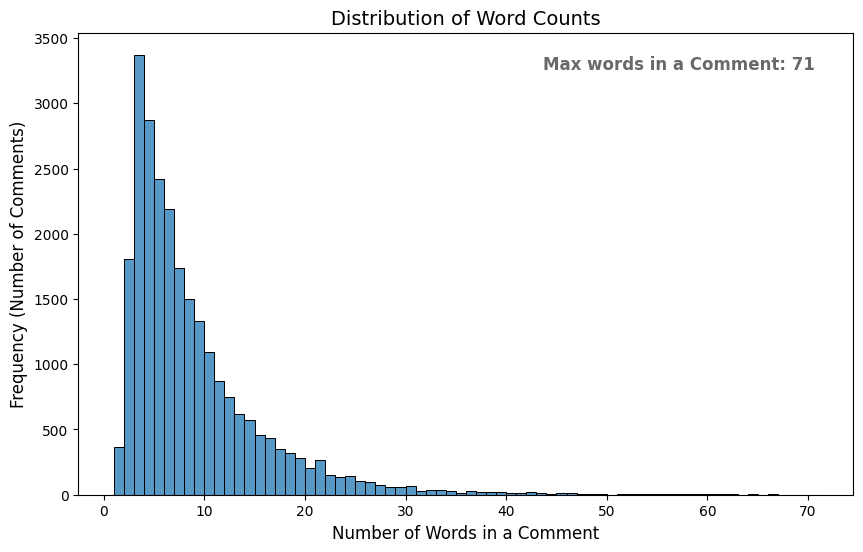

In [10]:
word_counts = [len(item.split()) for item in x_train]
max_word_count = max(word_counts)

plt.figure(figsize=(10, 6))
sns.histplot(word_counts, bins=range(1, max_word_count+1), kde=False)
plt.title('Distribution of Word Counts', fontsize=14)
plt.xlabel('Number of Words in a Comment', fontsize=12)
plt.ylabel('Frequency (Number of Comments)', fontsize=12)
plt.text(
    x=0.95, y=0.95,
    s=f'Max words in a Comment: {max_word_count}',
    color='dimgray', fontsize=12, fontweight='bold', ha='right', va='top',
    transform=plt.gca().transAxes
)
plt.show()

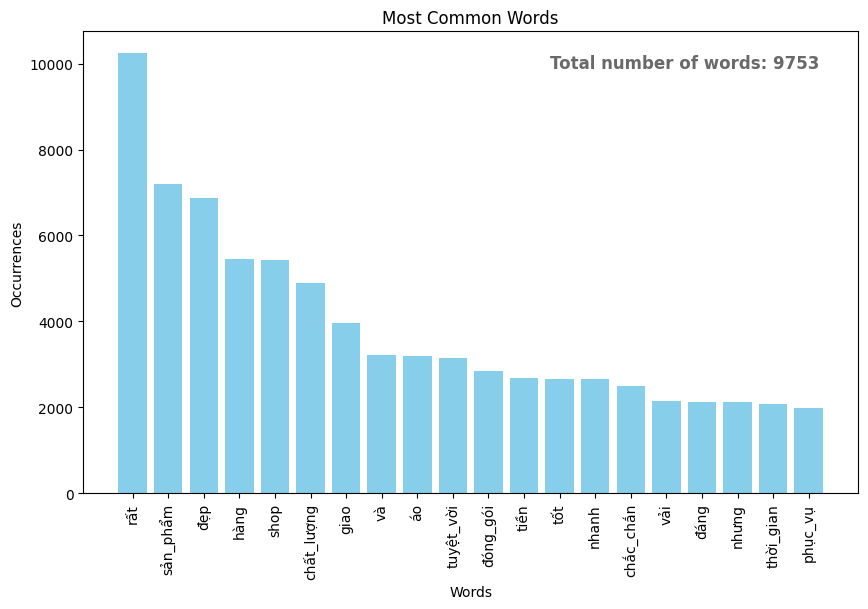

In [11]:
words = [word for comment in x_train for word in comment.split()]
word_counts = Counter(words)
most_common_words = Counter(words).most_common(20)
labels, values = zip(*most_common_words)

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Occurrences')
plt.title('Most Common Words')
plt.xticks(rotation=90)
plt.text(
    x=0.95, y=0.95, s=f'Total number of words: {len(word_counts)}',
    color='dimgray', fontsize=12, fontweight='bold', ha='right', va='top',
    transform=plt.gca().transAxes
)
plt.show()

In [12]:
model_name = 'vinai/phobert-base-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_length = 50

# Train
train_input_ids, train_attention_mask = preprocess_texts(tokenizer, x_train, max_length=max_length)

# Val
val_input_ids, val_attention_mask = preprocess_texts(tokenizer, x_val, max_length=max_length)

# Test
test_input_ids, test_attention_mask = preprocess_texts(tokenizer, x_test, max_length=max_length)

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [13]:
# Encode label
label_encoder = LabelEncoder()
label_encoder.fit(np.concatenate([y_train, y_val, y_test]))

y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print('Label mapping:', label_mapping)

Label mapping: {'NEG': 0, 'NEU': 1, 'POS': 2}


In [14]:
y_train_encoded = np.array(y_train_encoded)
y_val_encoded = np.array(y_val_encoded)
y_test_encoded = np.array(y_test_encoded)

## **Training**

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Layer, regularizers, optimizers
from utils.layers import BERTEncoder

In [16]:
# Input layers
input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
attention_mask = layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

# BERT Encoding
bert_output = BERTEncoder(model_name)([input_ids, attention_mask])

# BiLSTM Layer
lstm_output = layers.Bidirectional(
    layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
)(bert_output)

# Global Average Pooling and Global Max Pooling
avg_pool = layers.GlobalAveragePooling1D()(lstm_output)
max_pool = layers.GlobalMaxPooling1D()(lstm_output)

# Concatenate Pooling Outputs
concat = layers.Concatenate()([avg_pool, max_pool])

# Fully Connected Layers
dense_1 = layers.Dense(256, activation='relu')(concat)
dropout_1 = layers.Dropout(0.3)(dense_1)
dense_2 = layers.Dense(128, activation='relu')(dropout_1)
dropout_2 = layers.Dropout(0.3)(dense_2)

# Output Layer
output = layers.Dense(3, activation='softmax')(dropout_2)

# Final Model
final_model = Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile Model
optimizer = optimizers.Adam(learning_rate=1e-3)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]

final_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=metrics
)

# Model summary
final_model.summary()

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_encoder              │ (None, 50, 768)        │              0 │ input_ids[0][0],       │
│ (BERTEncoder)             │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50, 256)        │        918,528 │ bert_encoder[0][0]     │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 256)            │              0 │ bidirectional[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 256)            │              0 │ bidirectional[0][0]    │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 512)            │              0 │ global_average_poolin… │
│                           │                        │                │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        131,328 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 3)              │            387 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,083,139 (4.13 MB)

 Trainable params: 1,083,139 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
checkpoint_filepath = 'models/best_model.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = final_model.fit(
    x=[train_input_ids, train_attention_mask],
    y=y_train_encoded,
    validation_data=([val_input_ids, val_attention_mask], y_val_encoded),
    batch_size=64,
    epochs=50,
    callbacks=[checkpoint_callback, early_stopping]
)

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.7269 - loss: 0.6536
Epoch 1: val_loss improved from inf to 0.51538, saving model to models/best_model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 137s 307ms/step - accuracy: 0.7270 - loss: 0.6534 - val_accuracy: 0.7889 - val_loss: 0.5154
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.7951 - loss: 0.5048
Epoch 2: val_loss improved from 0.51538 to 0.50207, saving model to models/best_model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 116s 295ms/step - accuracy: 0.7951 - loss: 0.5048 - val_accuracy: 0.7905 - val_loss: 0.5021
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.8085 - loss: 0.4776
Epoch 3: val_loss improved from 0.50207 to 0.49463, saving model to models/best_model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 116s 295ms/step - accuracy: 0.8085 - loss: 0.4776 - val_accuracy: 0.7988 - val_loss: 0.4946
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.8144 - loss: 0.4571
Epoch 4: val_

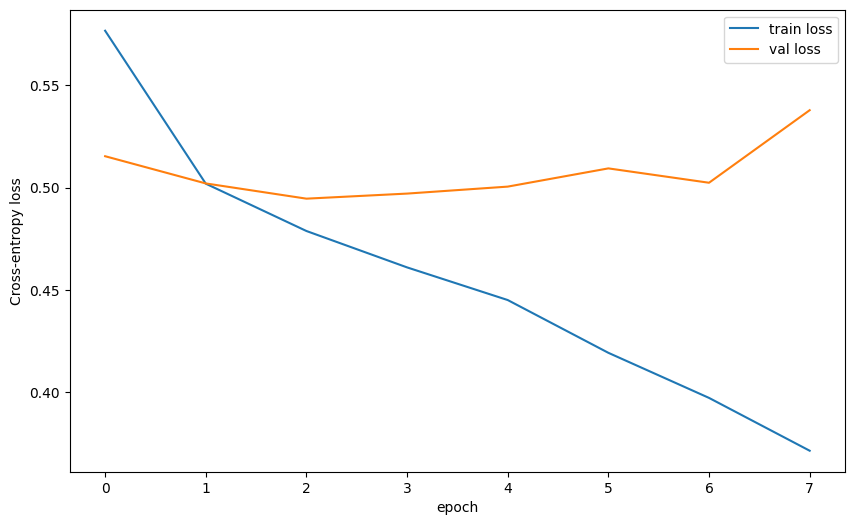

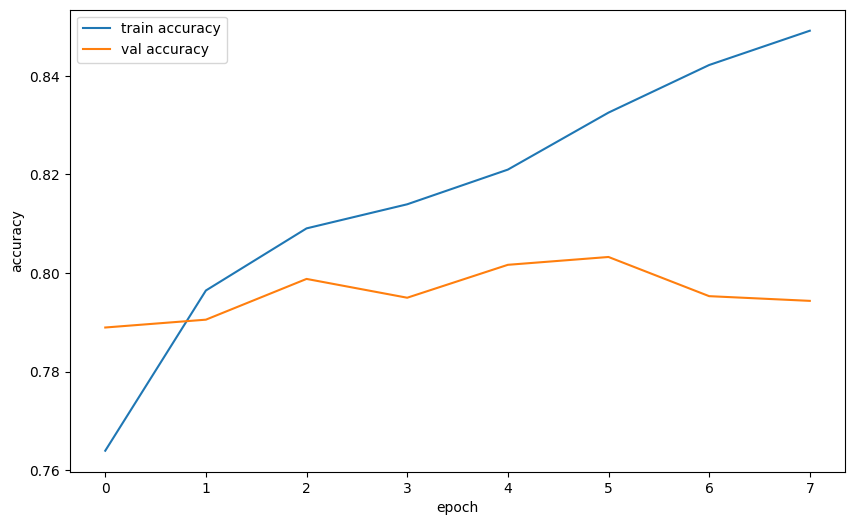

In [18]:
history = final_model.history

# Plot history loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epoch')
plt.ylabel('Cross-entropy loss')
plt.legend()
plt.show()

# Plot history accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [19]:
final_model.save('models/best_model.h5')

## **Model Evaluation**

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

In [21]:
y_pred_prob = final_model.predict([test_input_ids, test_attention_mask])
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()
print(classification_report(y_test_encoded, y_pred, target_names=['NEG', 'NEU', 'POS']))

99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step
              precision    recall  f1-score   support

         NEG       0.71      0.79      0.75       678
         NEU       0.45      0.27      0.34       476
         POS       0.88      0.93      0.91      1992

    accuracy                           0.80      3146
   macro avg       0.68      0.67      0.66      3146
weighted avg       0.78      0.80      0.79      3146



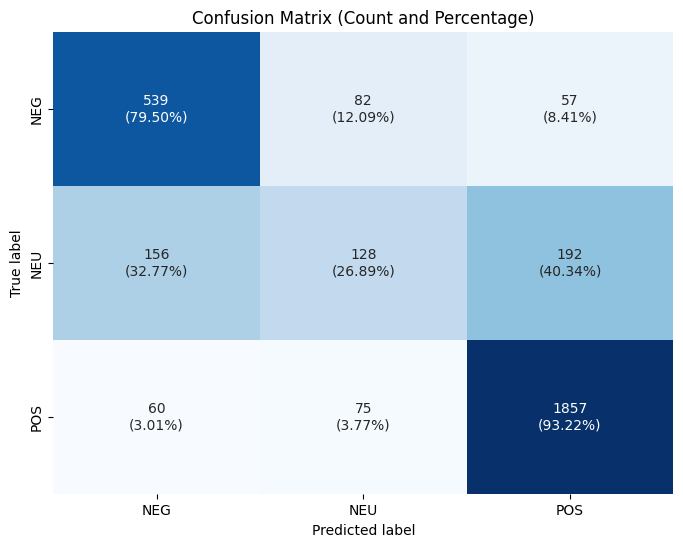

In [22]:
cm = confusion_matrix(y_test_encoded, y_pred)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = label_encoder.classes_

formatted_labels = [
    [f'{int(count)}\n({percentage:.2%})' for count, percentage in zip(row_count, row_percentage)]
    for row_count, row_percentage in zip(cm, cm_percentage)
]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=formatted_labels, fmt='', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Count and Percentage)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()